# StarEightyTwo + Mapping Prejudice: An Inter-rater Reliability Project

In [194]:
import os
os.chdir('/Users/jake/Documents/stareightytwo/projects/mapping_prejudice/assets/data')

from collections import Counter
from itertools import combinations
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

def handle_zero_division(x, y):
    try:
        return x/y
    except ZeroDivisionError:
        return None

### Begin by reading in the data...

In [197]:
df = pd.read_excel('mp_data.xlsx')
df.sort_values('Image_ID').head(10)

,Retired,User_Name,Class_ID,Class_Date,Match,Image_ID,Racial_Res,City,Addition,Lot,Block,Doc_ID,Grantor,Grantee,Date_Deed,Date_Ex
9357,Not Retired,user_53,56127273,2017-05-21 22:26:38 UTC,Yes,1028_0012_match.jpg,no person or persons other than of the Caucasi...,NaN,Edgewater on Nokomis,3,11,1719938,Estates Improvements Company,Evelyn C. Thompson,1933-05-10 00:00:00,1931-09-14 00:00:00
1056,Not Retired,user_222,32544767,2017-03-08 16:14:39 UTC,Yes,1028_0012_match.jpg,no person or persons other than of the Caucasi...,NaN,Edgewater on Nokomis,3,11,1719938,Estates Improvement Company,Evelyn C. Thompson,1933-05-10 00:00:00,1931-09-14 00:00:00
2235,Not Retired,user_222,35007042,2017-03-20 18:05:41 UTC,Yes,1028_0019_match.jpg,property hereby conveyed shall be used only fo...,NaN,Sunset Memorial Park,355,7B,1720373,"Memorial Park Association, Inc.",Warren Upham,1933-05-15 00:00:00,1933-01-21 00:00:00
22569,Not Retired,user_331,70785209,2017-09-16 18:08:28 UTC,I can't figure this one out.,1028_0062_match.jpg,"Missing first page with document number, addit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
1752,Not Retired,user_222,34061297,2017-03-15 18:35:02 UTC,I can't figure this one out.,1028_0062_match.jpg,deed exceeds 3 pages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
24453,Not Retired,user_440,72197247,2017-09-28 17:42:08 UTC,No,1028_0070_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
25334,Not Retired,user_126,72846401,2017-10-03 23:32:42 UTC,No,1028_0070_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
817,Not Retired,user_222,32093547,2017-03-06 13:20:38 UTC,No,1028_0070_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
24186,Not Retired,user_331,71939173,2017-09-27 02:30:56 UTC,Yes,1028_0082_match.jpg,that no person or persons other than of the Ca...,NaN,McNair Manor Second Unit,20,10,1723332,Gunnard Bergstrom and Ruth Alberta Bergstrom,Henry W. Lauderdale and Emily G. Lauderdale,1933-06-19 00:00:00,1932-04-26 00:00:00
31,Not Retired,user_222,29834369,2017-02-24 17:09:05 UTC,Yes,1028_0082_match.jpg,no person or persons other than of the Caucasi...,NaN,McNair Manor Second Unit,20,10,1723332,Gunnard & Ruth Alberta Bergstrom,Henry W. & Emily G. Lauderdale,1933-06-19 00:00:00,1932-04-26 00:00:00


## Exploratory analysis
### Classifications over time
Below, we can see a significant spike in classifications after the most recent Star Tribune article highlighting Mapping Prejudice's work. The first Strib article in 2016 doesn't show up here, as MP didn't open their project to the public until 2017.

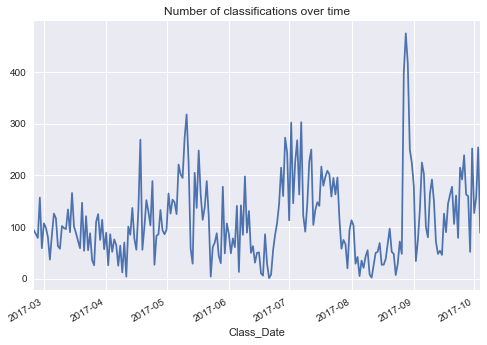

In [199]:
df['Class_Date'] = pd.to_datetime(pd.to_datetime(df['Class_Date']).astype(str).str.split().str[0])

df.groupby(['Class_Date']).size().plot(title='Number of classifications over time')

### How about the number of classifications by user?

In [200]:
gb = df.groupby('User_Name').size().sort_values(ascending=False)

print(gb.head(20))

User_Name
user_222    13550
user_331     1120
user_139     1041
user_161      566
user_304      546
user_256      379
user_452      360
user_248      305
user_531      290
user_520      256
user_235      222
user_513      219
user_485      211
user_528      207
user_234      205
user_171      204
user_24       194
user_124      188
user_13       179
user_377      154
dtype: int64


Wow, there are some star citizens in this volunteer base. How many volunteers does it take to get to 80% of classifications (whether retired or not)?

In [201]:
cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum     gb
User_Name                            
user_222    0.532856     13550  13550
user_331    0.576900     14670   1120
user_139    0.617838     15711   1041
user_161    0.640096     16277    566
user_304    0.661568     16823    546
user_256    0.676472     17202    379
user_452    0.690629     17562    360
user_248    0.702623     17867    305
user_531    0.714027     18157    290
user_520    0.724095     18413    256
user_235    0.732825     18635    222
user_513    0.741437     18854    219
user_485    0.749735     19065    211
user_528    0.757875     19272    207
user_234    0.765937     19477    205
user_171    0.773959     19681    204
user_24     0.781588     19875    194
user_124    0.788981     20063    188
user_13     0.796020     20242    179
(19, 3)


It only takes 19 volunteers to cover 80% of all completed classifications. What about "retired" classifications? What's the coverage like there?

In [202]:
gb = (df[df['Retired'] == 'Retired']
      .groupby('User_Name')
      .size()
      .sort_values(ascending=False))

cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum    gb
User_Name                           
user_222    0.338259      2541  2541
user_161    0.380724      2860   319
user_304    0.413072      3103   243
user_139    0.442758      3326   223
user_248    0.466853      3507   181
user_331    0.490415      3684   177
user_452    0.513578      3858   174
user_531    0.531017      3989   131
user_256    0.548456      4120   131
user_235    0.565495      4248   128
user_234    0.580937      4364   116
user_513    0.595714      4475   111
user_520    0.609957      4582   107
user_24     0.624201      4689   107
user_171    0.638445      4796   107
user_377    0.649494      4879    83
user_485    0.660410      4961    82
user_391    0.671193      5042    81
user_528    0.681709      5121    79
user_119    0.690761      5189    68
user_13     0.698482      5247    58
user_4      0.705538      5300    53
user_151    0.712460      5352    52
user_101    0.719249      5403    51
user_486    0.724973      5446    43
u

Okay, so 40 (out of 533) volunteers account for 80% of the retired classifications.

## What about overlap between classifications?
Specifically, is there enough across-rater coverage to warrant an inter-rater reliability examination?

In [203]:
overlap = {}

for user, user_df in df.groupby('User_Name'):
    overlap[user] = {}
    user_img_seen = set(user_df['Image_ID'])

    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        other_user_img_seen = set(other_df['Image_ID'])

        # Set intersection between what the user's seen and what the other user has seen
        common = user_img_seen & other_user_img_seen
        
        # Keep track of classifications in common and the number of in-common classifications (images seen)
        overlap[user][other_user] = {'common': common,
                                     'number': len(common)}

But wait! There's more (observations than we need). The approach above produces duplicates - the order in which *you and I* versus *I and you* share elements doesn't matter. We could have used `itertools.combinations`, but the following approach produces the same results:

In [204]:
# Remove duplicates... proxy for order-2 combinations
overlap_deduped = {}
for user in overlap:
    for other_user, values in overlap[user].items():
        # +1 for unordered keys
        overlap_deduped[frozenset((user, other_user))] = values
        
# Same thing!
assert len(overlap_deduped) == len(list(combinations(set(df['User_Name']), 2)))

Looking below, we can see a lot of (user, other user) combinations don't result in any overlap. Let's validate that every user has at least one overlap with another volunteer:

In [205]:
numbers = [overlap_deduped[fset]['number'] for fset in overlap_deduped]

sorted(Counter(numbers).most_common()[:10], key=lambda x: (-x[1], x[0]))

[(0, 139006),
 (1, 1835),
 (2, 342),
 (3, 160),
 (4, 99),
 (5, 47),
 (6, 42),
 (7, 26),
 (10, 18),
 (11, 14)]

Quite a few (user, other user) combos result in zero overlap. Well, let's at least check that all users have at least *one* overlap (i.e. one common image classified) with another user.

In [206]:
# All users have at least one overlap... use the original `overlap` with duplicates for this one
anything_for_user = [True if any(overlap[user][other_user]['number'] > 0 
                              for other_user in overlap[user]) 
                     else False for user in overlap]

assert all(x for x in anything_for_user), 'At least one user doesn\'t share any images with anyone else!'

Great! How about some descriptive statistics around the number of overlaps by user?

In [207]:
# Number of overlaps per user
n_overlaps_by_user = {user: sum(overlap[user][other_user]['number']
                                for other_user in overlap[user])
                      for user in overlap}

overlaps_no_dict = [n_overlaps for user, n_overlaps in n_overlaps_by_user.items()]

print('Summary statistics: number of overlaps with other users')
print('Mean: {}'.format(round(np.mean(overlaps_no_dict), 2)))
print('Median: {}'.format(np.median(overlaps_no_dict)))
print('Standard deviation: {}'.format(round(np.std(overlaps_no_dict), 2)))

Summary statistics: number of overlaps with other users
Mean: 59.35
Median: 6.0
Standard deviation: 529.32


There's definitely a lot of variation in the number of overlaps for each user. That's again due to one user who drives much of the classification for this project. That low median isn't all that promising, though, but I suppose it's in line with the Pareto information we observed above.

Let's look more at the distribution of overlaps.

In [208]:
n_overlaps_min, n_overlaps_max = min(overlaps_no_dict), max(overlaps_no_dict)

# Number of users with at least n common classifications
users_with_at_least = {n: sum(1 for i in overlaps_no_dict if i >= n)
                           for n in set(overlaps_no_dict)}

print('Number of users with at least...')
print('\n'.join('{} overlap(s): {} users'.format(overlaps, n_users) 
                for overlaps, n_users in sorted(users_with_at_least.items(), key=lambda x: -x[1])[:20]))

Number of users with at least...
1 overlap(s): 533 users
2 overlap(s): 482 users
3 overlap(s): 409 users
4 overlap(s): 365 users
5 overlap(s): 330 users
6 overlap(s): 288 users
7 overlap(s): 261 users
8 overlap(s): 239 users
9 overlap(s): 223 users
10 overlap(s): 205 users
11 overlap(s): 190 users
12 overlap(s): 181 users
13 overlap(s): 177 users
14 overlap(s): 170 users
15 overlap(s): 163 users
16 overlap(s): 160 users
17 overlap(s): 156 users
18 overlap(s): 149 users
19 overlap(s): 141 users
20 overlap(s): 133 users


We can see that the majority of users have fewer than ten images in common with other users. But not everything is doom and gloom! 133 users share at least twenty images, so that's probably good enough to get started with! Spoiling the surprise a bit, nearly 60 users share at least 50 overlaps. For what we're trying to accomplish, that ought to be a great start.

### Overlap heatmap for the most frequent volunteers

In [213]:
# Heatmap of top n volunteers' overlap totals
n = 20

# Original number of classifications by user
top_n_volunteers = gb.index[:n]

# Every volunteer has been compared with every other volunteer
# so all of these should be valid keys in `overlap_deduped`
top_vol_combos = list(map(frozenset, combinations(top_n_volunteers, 2)))

# Empty dataframe to fill with number of overlaps between volunteers
heatmap_df = pd.DataFrame(data=None, columns=top_n_volunteers, index=top_n_volunteers)

# Fill-in the table to eventually plot
for vol, other_vol in top_vol_combos:
    fs_key = frozenset((vol, other_vol))
    heatmap_df.loc[vol, other_vol] = overlap_deduped[fs_key]['number']
    
# In the case of no overlaps, populate zero
heatmap_df.fillna(0, inplace=True)

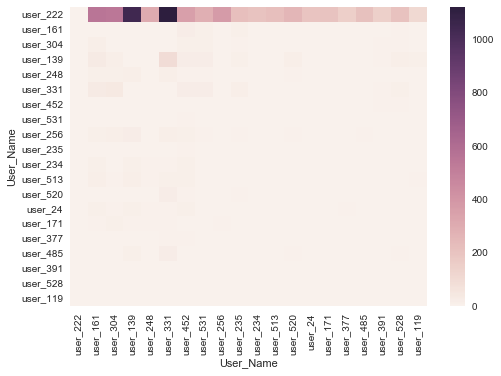

In [214]:
# Example from here: https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(heatmap_df)

plt.show()

In [215]:
# "Save" `df`, because we're going to make some modifications below
orig = df.copy(deep=True)

### Let's first take a look at the top *n* volunteers and how well they agree with each other.
Some volunteers have viewed the same image multiple times. For the sake of simplicity, each volunteer's "answer" for each image they've seen will be their most recent classification. This isn't a bad assumption, as I would venture to say volunteers have improved throughout their time classifying deeds.

In [216]:
df = orig.copy(deep=True)

df.sort_values('Class_Date', ascending=False, inplace=True)

# filter just to look at the top n volunteers
#df = df[df['User_Name'].isin(top_n_volunteers)]

df.drop_duplicates(subset=['User_Name', 'Image_ID'], inplace=True)

Now look at overlap *and* agreement between these volunteers... This is what we came here for...

In [220]:
overlap = []

for user, user_df in df.groupby('User_Name'):
    
    # Images the main user has seen and associated ratings  
    user_img_seen = dict(zip(user_df['Image_ID'], user_df['Match']))
    
    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        
        # Images the other user has seen and associated ratings
        other_user_img_seen = dict(zip(other_df['Image_ID'], other_df['Match']))
        
        # Set intersection between what the user's seen and what the other user has seen
        common = set(user_img_seen) & set(other_user_img_seen)

        # We only care to measure agreement between raters who have seen the same deeds
        if common:
            # Pairs of answers for each deed (image) commonly seen
            together = [(user_img_seen[img], other_user_img_seen[img])
                            for img in common]

            # Used to calculate Cohen's Kappa...
            # Just lists of each user's answers for all deeds shared
            user_vector = [x[0] for x in together]
            other_user_vector = [x[1] for x in together]

            # Can use sklearn.metrics.cohen_kappa_score, 
            #but should go through exercise of actually calculating...
            # http://psych.unl.edu/psycrs/handcomp/hckappa.PDF
            
            # If cohen_kappa_score returns np.nan, then we know each user agreed 100%...
            # but there was no "random chance" component
            
            # https://github.com/scikit-learn/scikit-learn/issues/9624
            # "1 in Cohen's Kappa indicates perfect agreement 
            # with 0 chance of agreement at random.
            # Here there is perfect agreement at random."
            
            # Cohen's Kappa can be zero when one rater 
            # gives the same answer for every subject
            # (e.g. in the case) of a "no" troll
            cohen_kappa = cohen_kappa_score(user_vector, other_user_vector)
                        
            if not np.isnan(cohen_kappa):
                # Set of IDs agreed- and disagreed-upon
                agreements = {img for img in common 
                              if user_img_seen[img] == other_user_img_seen[img]}
                
                disagreements = {img for img in common 
                                 if user_img_seen[img] != other_user_img_seen[img]}
                
                n_common = len(common)
                n_agreements = len(agreements)
                n_disagreements = len(disagreements)

                # Keep track of classifications in common and the 
                # number of in-common classifications (images seen)
                overlap.append(
                    {
                    'user': user,
                    'other_user': other_user,
                    'cohen_kappa': cohen_kappa,
                    'n_in_common': n_common,
                    'user_together_drop_dupe': frozenset((user, other_user)),

                    # The following are relatively more naive measures of reliability...
                    'n_agreements': n_agreements,
                    'n_disagreements': n_disagreements,
                    'perc_agreements': handle_zero_division(n_agreements, n_common),
                    'perc_disagreements': handle_zero_division(n_disagreements, n_common),
                    'agree_disagree_ratio': handle_zero_division(n_agreements, n_disagreements)
                    }
                )

agreement_df = pd.DataFrame.from_records(overlap)

/Users/jake/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:350: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Here's a sample of the dataframe we just put together:

In [221]:
agreement_df.sort_values(['n_in_common', 'cohen_kappa'], ascending=False).head()

,agree_disagree_ratio,cohen_kappa,n_agreements,n_disagreements,n_in_common,other_user,perc_agreements,perc_disagreements,user,user_together_drop_dupe
690,12.023256,0.868319,1034,86,1120,user_331,0.923214,0.076786,user_222,"(user_222, user_331)"
1301,12.023256,0.868319,1034,86,1120,user_222,0.923214,0.076786,user_331,"(user_222, user_331)"
188,20.687500,0.920297,993,48,1041,user_222,0.953890,0.046110,user_139,"(user_222, user_139)"
536,20.687500,0.920297,993,48,1041,user_139,0.953890,0.046110,user_222,"(user_222, user_139)"
302,41.923077,0.958473,545,13,558,user_222,0.976703,0.023297,user_161,"(user_222, user_161)"


Let's take a look at the most reliable raters, according to Cohen's Kappa:

In [222]:
(agreement_df
 .groupby('user')[['cohen_kappa', 'n_in_common']]
 .agg({'cohen_kappa': np.mean, 'n_in_common': np.sum})
 .sort_values(by=['cohen_kappa', 'n_in_common'], ascending=False)
 .head(10))

,cohen_kappa,n_in_common
user,,
user_493,1.0,41
user_123,1.0,33
user_19,1.0,18
user_370,1.0,16
user_54,1.0,16
user_350,1.0,15
user_310,1.0,14
user_64,1.0,14
user_120,1.0,12


The folks above are some of our best candidates for becoming the "source of truth" when ratings between volunteers become conflicted.

How about the *least* reliable raters?

In [223]:
(agreement_df
 .groupby('user')[['cohen_kappa', 'n_in_common']]
 .agg({'cohen_kappa': np.mean, 'n_in_common': np.sum})
 .sort_values(by=['cohen_kappa', 'n_in_common'], ascending=[True, False])
 .head(20))

,cohen_kappa,n_in_common
user,,
user_40,-0.111111,4
user_207,-0.100000,5
user_306,-0.040625,15
user_328,-0.033333,9
user_1,0.000000,79
user_518,0.000000,11
user_498,0.000000,8
user_125,0.000000,7
user_226,0.000000,6


We can see that some users have negative average Kappas (which is rare), indicating that their average agreement with others was less than what might be expected by random chance. There are also some users, e.g. `user_1`, who are most likely trolls, with an average Kappa value of 0.0 and many classifications completed.

In [224]:
df[df['User_Name'].isin('user_40 user_207 user_306 user_1'.split())].sort_values('User_Name')

,Retired,User_Name,Class_ID,Class_Date,Match,Image_ID,Racial_Res,City,Addition,Lot,Block,Doc_ID,Grantor,Grantee,Date_Deed,Date_Ex
15188,Retired,user_1,63346546,2017-07-12,No,2002_0451_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15193,Not Retired,user_1,63347187,2017-07-12,No,1121_0136_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15194,Not Retired,user_1,63347205,2017-07-12,No,1254_0628_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15195,Retired,user_1,63347214,2017-07-12,No,1462_0411_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15196,Retired,user_1,63347227,2017-07-12,No,1491_0114_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15197,Not Retired,user_1,63347232,2017-07-12,No,1527_0014_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15198,Not Retired,user_1,63347237,2017-07-12,No,1662_0538_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15192,Not Retired,user_1,63347180,2017-07-12,No,1118_0125_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15199,Not Retired,user_1,63347243,2017-07-12,No,1966_0292_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
15201,Not Retired,user_1,63347264,2017-07-12,No,2003_0289_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null


It's plain to see that this person is just saying "no" for every image. Going forward, we'll exclude them from any further rater-reliability exam. That's not to say some of the other lowest-scoring raters aren't trolls, either, but they warrant a little more investigation...

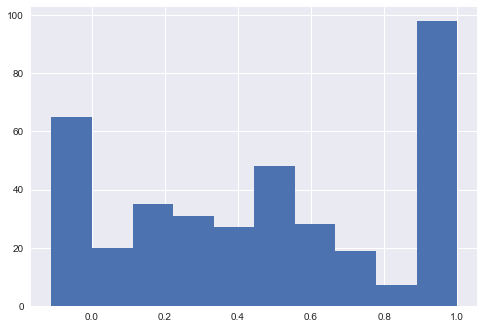

In [225]:
# Want to remove user_1 and any associated rater-rater pairs in which he or she was involved...
agreement_df = agreement_df[agreement_df.index.isin(idx for idx in agreement_df.index 
                                                    if not 'user_1' in agreement_df.loc[idx, 'user_together_drop_dupe'])]

avg_kappa = agreement_df.groupby(['user'])['cohen_kappa'].mean()

avg_kappa.hist()

We see that, on average, most of the raters are pretty reliable! It's subjective, of course, but most statisticians agree that a Kappa value greater than 0.5 indicates "moderate" to "good" agreement. A Kappa of 1 indicates perfect agreement over random chance.

But there are some raters lacking a little bit, near the left side of the distribution:

In [226]:
# Users with whom MP could potentially follow-up for more training...
# Some of these users have seen quite a few images!
gb[gb.index.isin(avg_kappa[(avg_kappa <= 0.5) & (avg_kappa > 0)].index)].to_frame('n_clfs').head(10)

,n_clfs
User_Name,
user_531,131
user_256,131
user_377,83
user_485,82
user_391,81
user_119,68
user_151,52
user_86,42
user_411,40


The unfortunate thing about some of these less-reliable raters is that many of them seem to have completed a handful of classifications, done very poorly (relative to others), and stopped classifying. But from above we can see there are some prolific volunteers still out there that might benefit from some more guidance/training.

In [227]:
df['classifications'] = 1

(df[df['User_Name'].isin(avg_kappa[(avg_kappa <= 0.5) & (avg_kappa > 0)].index)]
 .groupby('User_Name').agg({'classifications': np.sum, 'Class_Date': np.max})
 .sort_values('Class_Date', ascending=False)
 .head(20))

,classifications,Class_Date
User_Name,,
user_103,19,2017-10-04
user_75,5,2017-10-04
user_70,13,2017-10-04
user_228,12,2017-10-04
user_181,4,2017-10-04
user_158,5,2017-10-04
user_126,16,2017-10-03
user_387,6,2017-10-03
user_265,3,2017-10-03


Until that training is completed, we can use a better metric than just the average of each rater's other-rater Cohen's Kappa values. Shouldn't we account for the number of classifications completed by each volunteer? A volunteer with only five shared images could easily score an average Cohen's Kappa score of 1.0, but are they really more reliable than a rater with 0.80 and 500 shared images? I'd rather take the wisdom of the more experienced volunteer in this case.

In [228]:
# Number of classifications for each user
num_clfs = df.groupby(['User_Name']).size().to_frame('n_clfs')

# Put together the number of classifications and Cohen's Kappa values for each user
reliability_df = pd.concat((avg_kappa, num_clfs), axis=1)

# Product of each user's Cohen's Kappa score and the log of the number of classifications completed
# There are diminishing "returns" to an increasing number of shared images...
# The effect will always be positive, but incremental gains early on are much more rewarding than later on
reliability_df['reliability_score'] = reliability_df['cohen_kappa'] * np.log(reliability_df['n_clfs'])

print('{} Most-reliable raters {}'.format(*('*'*5,)*2))
print(reliability_df.sort_values('reliability_score', ascending=False).head(25))

print('\n{} Least-reliable raters {}'.format(*('*'*5,)*2))
print(reliability_df[reliability_df['reliability_score'].notnull()].sort_values('reliability_score', ascending=False).tail(10))

***** Most-reliable raters *****
          cohen_kappa  n_clfs  reliability_score
user_222     0.677191   13503           6.440540
user_139     0.664635    1041           4.617842
user_304     0.701135     546           4.418986
user_161     0.673606     560           4.262535
user_331     0.602023    1120           4.226853
user_234     0.728045     205           3.875388
user_520     0.690685     256           3.829972
user_452     0.634022     360           3.731917
user_386     0.858391      65           3.583258
user_493     1.000000      33           3.496508
user_24      0.640844     194           3.375873
user_123     1.000000      28           3.332205
user_431     0.716968      95           3.264983
user_93      0.723541      86           3.222902
user_528     0.594500     207           3.170304
user_124     0.603052     187           3.154632
user_13      0.605247     179           3.139650
user_209     0.786526      51           3.092482
user_381     0.931818      27       

In [229]:
reliability_df.reset_index().to_csv('user_ratings.csv', index=False)

### Of the top *n* raters, how many unique images have they covered?

In [230]:
imgs_covered = set(df[df['User_Name'].isin(top_n_volunteers)]['Image_ID'].dropna())

print('Percentage of images covered by top {} volunteers: {}'
      .format(n, round(len(imgs_covered)/len(set(df['Image_ID'].dropna())), 2)))

Percentage of images covered by top 20 volunteers: 1.0


Great, so we know now that we have 100% coverage across all deeds for the top 50 most prolific (not necessarily - at this point - highest-rated... work on that) volunteers. That means, in the case of a tie, we can defer to the most reliable of those top 50 volunteers.

## Future enhancements
* Exclude from the reliability-score calculation trolls and other *really* unreliable volunteers
* Explore other meta-metrics for reliability score
* Explore other rater-reliability metrics, e.g. Krippendorff's Alpha

## Manually calculate Cohen's Kappa
Want to try this out yourself? Get the data from [here](http://bit.ly/2hmNJEQ).

In [231]:
a = ['no', 'no', 'no', 'yes', 'yes', 'yes', 'no',
     'maybe', 'no', 'maybe', 'maybe', 'maybe',
     'maybe', 'maybe', 'maybe']

b = ['no', 'yes', 'no', 'no', 'yes', 'no', 'yes',
     'maybe', 'no', 'maybe', 'maybe', 'yes',
     'maybe', 'maybe', 'maybe']

Build your contingency table. We could use [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), but let's build things from scratch...

In [232]:
unique_vals = set(a) | set(b)

contin_tb = pd.DataFrame(data=np.zeros((len(unique_vals), len(unique_vals))),
                         index=unique_vals,
                         columns=unique_vals)

for rater_a_obs, rater_b_obs in zip(a, b):
    contin_tb.loc[rater_a_obs, rater_b_obs] += 1

Next, get the row- and column-wise totals, as well as the overall total number of cases viewed by both raters:

In [233]:
row_total = contin_tb.sum(axis=0)
column_total = contin_tb.sum(axis=1)

overall_total = (row_total).sum()

We'll need to obtain the total number of agreements and divide by the total number of cases viewed to get the probability of agreement:

In [234]:
# Sum along diagonal... total number of agreements
agreements = np.trace(contin_tb)

pr_a = agreements/overall_total

Next, in order to calculate the expected number of agreements due to random chance, we'll grab the row- and column-wise percentages of the total number of classifications. `pr_e` is the probability that these two raters would agree due to random chance, and can be understood fairly easily: if rater A says "yes" to *p_a* percent of the cases, and rater B says "yes" to *p_b* percent of the cases, we can expect that these two independent raters will agree by chance on (*p_a* x *p_b*) x *n* cases.

In [235]:
row_perc = row_total/overall_total
column_perc = column_total/overall_total

pr_e = (row_perc * column_perc).sum()

In [236]:
# (Pr(a) - Pr(e))/(1-Pr(e))
kappa = (pr_a - pr_e)/(1 - pr_e)

print(kappa)

0.486301369863


In [237]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(a, b))

0.486301369863
